In [2]:
from pathlib import Path 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')      
sns.set()
import warnings
warnings.filterwarnings("ignore")

## Reading files 

In [3]:
DATA_FOLDER = Path('../data/splits')
path = Path('../predictions')

In [4]:
test_interactions = pd.read_csv(DATA_FOLDER / 'test_interactions.csv', index_col=False)
val_interactions = pd.read_csv(DATA_FOLDER / 'val_interactions.csv', index_col=False)
train_interactions = pd.read_csv(DATA_FOLDER / 'train_interactions.csv', index_col=False)

In [5]:
from ast import literal_eval
proteins = pd.read_csv('../data/BindingDB_1chain_proteins_all.csv', index_col=False)
proteins.head()
def literal_return(val):
    try:
        if not pd.isnull(val):
            return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val
    
    
proteins['families'] = proteins['families'].apply(literal_return)
proteins['DrugBank'] = proteins['DrugBank'].apply(literal_return)
proteins['GO_Component'] = proteins['GO_Component'].apply(literal_return)
proteins['GO_Function'] = proteins['GO_Function'].apply(literal_return)
proteins['GO_Process'] = proteins['GO_Process'].apply(literal_return)
proteins['clans'] = proteins['clans'].str.replace('(nan, nan)', '"-", "-"')
proteins['clans'] = proteins['clans'].apply(literal_return)

def collect_tuple_items(items):
    if type(items) == list:
        return [item[0] + ':' + item[1] for item in items if not pd.isnull(item[0])]
    else:
        return []
proteins['Family_ids'] = proteins['families'].apply(collect_tuple_items)
proteins['GO_function_ids'] = proteins['GO_Function'].apply(collect_tuple_items)
proteins['GO_component_ids'] = proteins['GO_Component'].apply(collect_tuple_items)
proteins['GO_process_ids'] = proteins['GO_Process'].apply(collect_tuple_items)
proteins['Clan_ids'] = proteins['clans'].apply(collect_tuple_items)

In [6]:
train_interactions = train_interactions.merge(proteins)

In [18]:
def read_files(folder):
    files = {}
    for split in ['test', 'val']:
        files[f'{split}_overall'] = pd.read_csv(folder / f'{split}_overall.csv', index_col = False).assign(path=str(folder)).assign(split=split)
        files[f'{split}_target'] = pd.read_csv(folder / f'{split}_targets.csv', index_col = False).assign(path=str(folder)).assign(split=split)
        files[f'{split}_prediction'] = pd.read_json(folder / f'{split}_predictions.json').assign(path=str(folder)).assign(split=split)
    return files
   
def collect_results(path):
    output_folders = [f.parent for f in path.glob("**/*") if 'test_overall.csv' == f.name]
    all_files = []
    for folder in output_folders: 
        try:
            all_files.append(read_files(folder))       
        except:
            print(folder)
    frames = []
    for f_type in ['overall', 'target', 'prediction']:
        frames.append(pd.concat([item[f'{split}_{f_type}'] for item in all_files for split in ['test', 'val']]))

    return frames 


def clean_frame(df):
    df['model'] = df['path'].apply(lambda x: Path(x).name)
    df = df[df['model'].isin(['EncDecLM', 'EncDecBase', 'T5'])]   
    return df

df_overall_scores, df_target_scores, df_predictions = map(clean_frame, collect_results(path))

In [31]:
train_split_metrics = pd.read_json(DATA_FOLDER / 'split_similarities.json').transpose()

In [33]:
def aggregate_molecules(df, groups):
    pred_groups = df.groupby(groups)
    predictions = {}
    for table, group in pred_groups:
        predictions[table] = {}
        molecules = {}
        for row, data in group.iterrows():  
            for col in group.columns:
                if type(data[col]) == list:
                    if col in predictions[table]:
                        predictions[table][col].extend(data[col])
                    else:
                        predictions[table][col] = data[col]
    return pd.DataFrame(predictions).transpose()

df_test_agg_predictions = aggregate_molecules(df_predictions[df_predictions['split'] == 'test'], ['split', 'model'])
df_val_agg_predictions = aggregate_molecules(df_predictions[df_predictions['split'] == 'val'], ['split', 'model'])

In [34]:
pd.DataFrame(df_test_agg_predictions['beam']['test']['EncDecBase']).to_csv('encdecbase.csv')

## Benchmarking metrics

In [36]:
pd.options.display.float_format = '{:,.3f}'.format
df_overall_scores[df_overall_scores['split'] == 'test'][['model', 'strategy', 'valid', 'unique', 'novelty', 'FCD', 'Scaf', 'SNN', 'IntDiv', 'Filters']].sort_values(by=['strategy'])

,model,strategy,valid,unique,novelty,FCD,Scaf,SNN,IntDiv,Filters
0,EncDecBase,beam,0.961,0.780,0.978,11.652,0.100,0.572,0.863,0.748
0,EncDecLM,beam,0.984,0.795,0.965,9.454,0.090,0.560,0.871,0.699
0,T5,beam,0.862,0.909,0.999,19.520,0.043,0.506,0.831,0.827
1,EncDecBase,sampling,0.840,0.986,0.996,4.366,0.085,0.389,0.872,0.781
1,EncDecLM,sampling,0.908,0.967,0.992,4.519,0.088,0.413,0.871,0.782
1,T5,sampling,0.664,1.000,1.000,4.688,0.032,0.341,0.865,0.815


In [37]:
df_overall_scores[df_overall_scores['split'] == 'val'][['model', 'strategy', 'valid', 'unique', 'novelty', 'FCD', 'Scaf', 'SNN', 'IntDiv', 'Filters']].sort_values(by=['strategy'])

,model,strategy,valid,unique,novelty,FCD,Scaf,SNN,IntDiv,Filters
0,EncDecBase,beam,0.980,0.738,0.969,11.128,0.130,0.572,0.862,0.806
0,EncDecLM,beam,0.991,0.768,0.954,9.377,0.135,0.574,0.869,0.809
0,T5,beam,0.877,0.888,0.998,18.237,0.055,0.496,0.831,0.850
1,EncDecBase,sampling,0.847,0.978,0.993,4.191,0.129,0.398,0.873,0.797
1,EncDecLM,sampling,0.914,0.962,0.988,4.168,0.152,0.433,0.873,0.821
1,T5,sampling,0.644,1.000,1.000,4.426,0.044,0.344,0.866,0.811


In [93]:
train_split_metrics.reset_index(inplace=True)

## Jensen Shannon Distance

In [41]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, gaussian_kde, wasserstein_distance
from scipy import histogram
import random

def continuous_JSD(original_dist, generated_dist, tol=1e-10):
    if all(v == 0 for v in generated_dist):
        return None
    gen_kde = gaussian_kde(generated_dist)
    org_kde = gaussian_kde(original_dist)
    vec = np.hstack([generated_dist, original_dist])
    x_eval = np.linspace(vec.min(), vec.max(), num=1000)
    P = gen_kde(x_eval) + tol
    Q = org_kde(x_eval) + tol
    return jensenshannon(P, Q)

def discrete_JSD(generated_dist, original_dist, tol=1e-10):
    gen, bins = histogram(generated_dist, density=True)
    org, bins = histogram(original_dist, density=True)
    gen += tol
    org += tol
    return jensenshannon(gen, org)

def compute_distance(values, metric='FCD', dist='wasserstein'):
    values = [x for x in values if str(x) != 'nan']
    train_clean = [x for x in train_split_metrics[metric].values.tolist() if str(x) != 'nan']
    if dist == 'wasserstein':
        return wasserstein_distance(random.sample(train_clean, len(values)), values)
    elif dist == 'jensen-shannon':
        return jensenshannon(random.sample(train_clean, len(values)), values)
    else:
        return continuous_JSD(train_clean, values)

pd.options.display.float_format = '{:,.3f}'.format
    
output_df = df_target_scores.copy()

df_target_stats_fcd_a = output_df.groupby(['model', 'strategy'])['FCD'].apply(list).reset_index(name='FCD_list')
df_target_stats_fcd_a['FCD_CJS'] = df_target_stats_fcd_a['FCD_list'].apply(compute_distance, dist='cjensen-shannon')

df_target_stats_fcd_a.sort_values(by=['strategy', 'model', 'FCD_CJS'])[['strategy', 'model', 'FCD_CJS']]

,strategy,model,FCD_CJS
0,beam,EncDecBase,0.564
2,beam,EncDecLM,0.556
4,beam,T5,0.681
1,sampling,EncDecBase,0.603
3,sampling,EncDecLM,0.586
5,sampling,T5,0.684


## Supplementary Figures

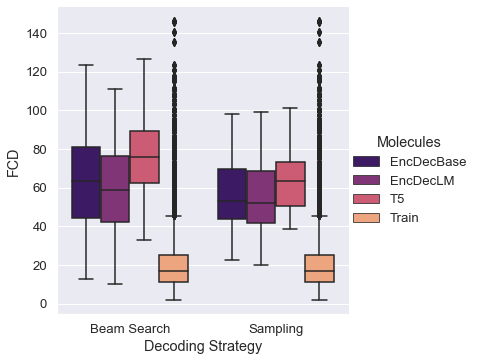

In [45]:
sns.set_context("paper")
sns.set(font_scale = 1.2)
output_df = df_target_scores[df_target_scores['split'] == 'test']

output_df = pd.concat([output_df, train_self_metrics])
output_df = output_df.replace('beam', 'Beam Search')
output_df = output_df.replace('sampling', 'Sampling')
output_df['Molecules'] = output_df['model']
output_df['Decoding Strategy'] = output_df['strategy']

sns.catplot(x="Decoding Strategy", y="FCD", hue="Molecules", palette="magma", kind='box', data=output_df.sort_values(by=['model'])) #[output_df['dataset'] == '100%'])

plt.savefig('../figures/target_FCD_box.pdf')  

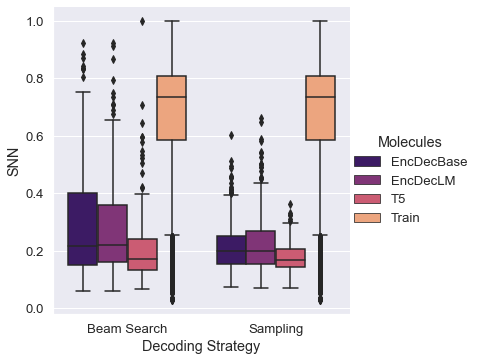

In [48]:
output_df = df_target_scores[df_target_scores['split'] == 'test']

output_df = pd.concat([output_df, train_self_metrics])
output_df = output_df.replace('beam', 'Beam Search')
output_df = output_df.replace('sampling', 'Sampling')
output_df['Molecules'] = output_df['model']
output_df['Decoding Strategy'] = output_df['strategy']

sns.catplot(x="Decoding Strategy", y="SNN", hue="Molecules", palette="magma", kind='box', data=output_df.sort_values(by=['model']))
plt.savefig('../figures/target_SNN_box.pdf')  